In [1]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import math

To commit:
In terminal
cp "Risk visualizer.ipynb" "C:\Users\hkrin\DSB\"
git add "Risk visualizer.ipynb" in git bash
git commit -m "text" in git bash
git push

In [2]:
def say_something(x):
    """
    Print the current widget value in short sentence
    """
    print(f'Widget says: {x}')
 
widgets.interact(say_something, x=[0, 1, 2, 3])
widgets.interact(say_something, x=(0, 10, 1))
widgets.interact(say_something, x=(0, 10, .5))
_ = widgets.interact(say_something, x=True)

interactive(children=(Dropdown(description='x', options=(0, 1, 2, 3), value=0), Output()), _dom_classes=('widg…

interactive(children=(IntSlider(value=5, description='x', max=10), Output()), _dom_classes=('widget-interact',…

interactive(children=(FloatSlider(value=5.0, description='x', max=10.0, step=0.5), Output()), _dom_classes=('w…

interactive(children=(Checkbox(value=True, description='x'), Output()), _dom_classes=('widget-interact',))

interactive(children=(IntSlider(value=1, description='w', max=10), FloatSlider(value=1.0, description='amp', m…

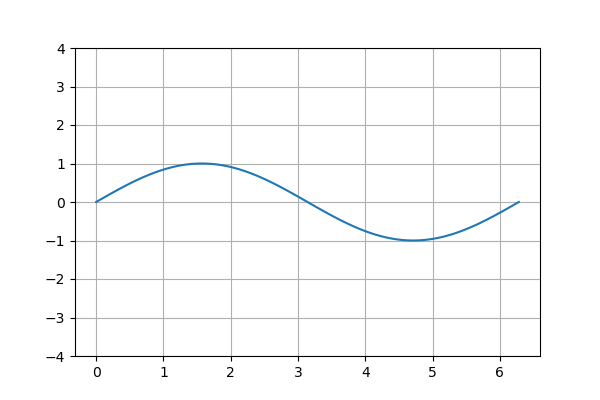

In [3]:
# set up plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_ylim([-4, 4])
ax.grid(True)
 
# generate x values
x = np.linspace(0, 2 * np.pi, 100)
 
 
def my_sine(x, w, amp, phi):
    """
    Return a sine for x with angular frequeny w and amplitude amp.
    """
    return amp*np.sin(w * (x-phi))
 
 
@widgets.interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi+0.01, 0.01))
def update(w = 1.0, amp=1, phi=0):
    """Remove old lines from plot and plot new one"""
    [l.remove() for l in ax.lines]
    ax.plot(x, my_sine(x, w, amp, phi), color='C0')

interactive(children=(IntSlider(value=50, description='rad'), IntSlider(value=180, description='angle', max=36…

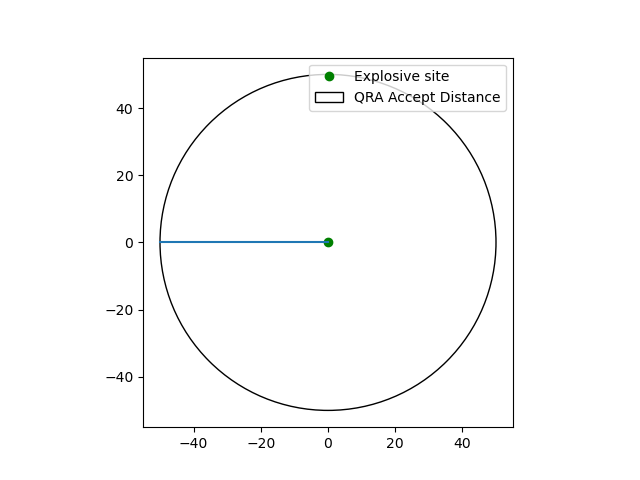

In [86]:
fig, ax = plt.subplots()
@widgets.interact(rad=(0, 100, 1),angle=(0, 360, 1))
def update(rad,angle):
    plt.cla()
    ax.grid(False)
    ax.set_aspect(1)
    #plot dot in origin
    ax.plot(0, 0, 'go', label='Explosive site')
    accept_radii = Circle((0,0),rad, fill=False, label='QRA Accept Distance')
    ax.set_ylim([-(rad+5), rad+5])
    ax.set_xlim([-(rad+5), rad+5])
    ax.add_artist(accept_radii)

    # find the end point
    endy = 0 + rad * np.sin(np.radians(angle))
    endx = rad * np.cos(np.radians(angle))

    # plot the points
    ax.plot([0, endx], [0, endy])
ax.legend();